# Getting started with the eemeter library

This jupyter notebook is an interactive tutorial. It walks through loading data, running the CalTRACK methods, and plotting results. You'll run all the code yourself. Run through from the top and use `<shift><enter>` to run cells. If you feel so inspired, make edits and go deeper if you'd like.

In [1]:
# turn on inline plotting
%matplotlib inline

In [2]:
import eemeter

## Loading data

Let's load up some meter and temperature data from samples that come packaged with the eemeter. The samples we are loading up are two versions of the same underlying data - one in billing data form, one it daily data form. We are expecting roughly equivalent results for each.

*Note: the sample data is simulated, not real!*

In [3]:
meter_data_billing, temperature_data_billing, metadata_billing = \
    eemeter.load_sample('il-electricity-cdd-hdd-billing_monthly')

meter_data_daily, temperature_data_daily, metadata_daily = \
    eemeter.load_sample('il-electricity-cdd-hdd-daily')

The metadata has project start and end that we can use to determine a baseline period.

In [4]:
baseline_end_date = metadata_billing['blackout_start_date']
baseline_end_date

datetime.datetime(2016, 12, 26, 0, 0, tzinfo=<UTC>)

The convention for formatting meter data is to create a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) with a [DatetimeIndex](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html) and a column of meter readings called `value`. The index datetime values represent the start dates of each metering period. The end of each period is the start of the next period, even for data with variable period lengths like billing data. The end date of the last period can be supplied by appending an extra period with the final end date and a NaN value. Missing data is represented by one or more periods of value NaN. Data should be sorted by time and deduplicated prior to use with eemeter.

In [5]:
meter_data_daily.head()

,value
start,
2015-11-22 00:00:00+00:00,32.34
2015-11-23 00:00:00+00:00,23.80
2015-11-24 00:00:00+00:00,26.26
2015-11-25 00:00:00+00:00,21.32
2015-11-26 00:00:00+00:00,6.70


In [6]:
meter_data_billing.tail()

,value
start,
2017-09-26 06:00:00+00:00,526.25
2017-10-27 06:00:00+00:00,649.80
2017-11-25 06:00:00+00:00,650.52
2017-12-22 06:00:00+00:00,1393.40
2018-01-20 06:00:00+00:00,NaN


The convention for formatting temperature is as a [pandas Series](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html), also with a [DatetimeIndex](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html).

In [7]:
temperature_data_daily.head()

dt
2015-11-22 06:00:00+00:00    21.01
2015-11-22 07:00:00+00:00    20.35
2015-11-22 08:00:00+00:00    19.38
2015-11-22 09:00:00+00:00    19.02
2015-11-22 10:00:00+00:00    17.82
Freq: H, Name: tempF, dtype: float64

In [8]:
temperature_data_billing.head()

dt
2015-11-22 06:00:00+00:00    21.01
2015-11-22 07:00:00+00:00    20.35
2015-11-22 08:00:00+00:00    19.38
2015-11-22 09:00:00+00:00    19.02
2015-11-22 10:00:00+00:00    17.82
Freq: H, Name: tempF, dtype: float64

## Plotting (part 1)

Let's use some eemeter plotting functions to see what our data looks like.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f30bda5aac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f30bd8c0978>)

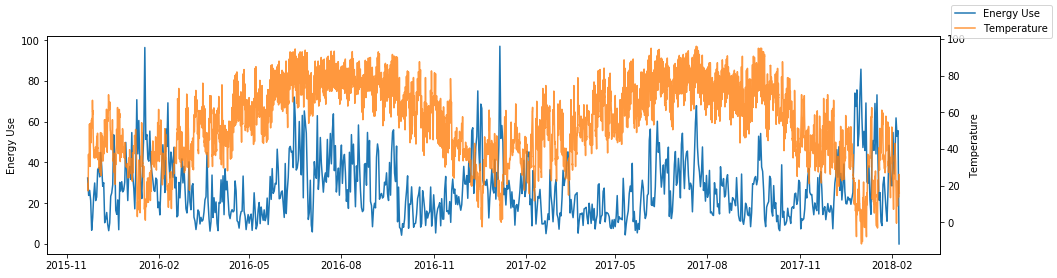

In [9]:
eemeter.plot_time_series(meter_data_daily, temperature_data_daily, figsize=(16, 4))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f30bd98efd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f30ba074240>)

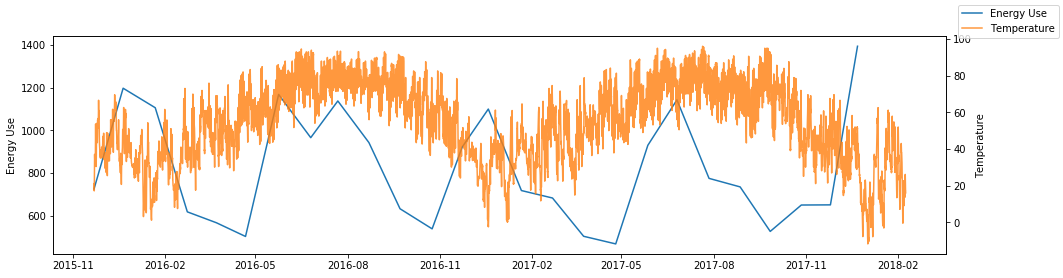

In [10]:
eemeter.plot_time_series(meter_data_billing, temperature_data_billing, figsize=(16, 4))

The following plots the two versions - billing and daily - one on top of the other in energy signature form. This shows the temperature dependece of usage on external temperatures. (Remember - this data is simulated!)

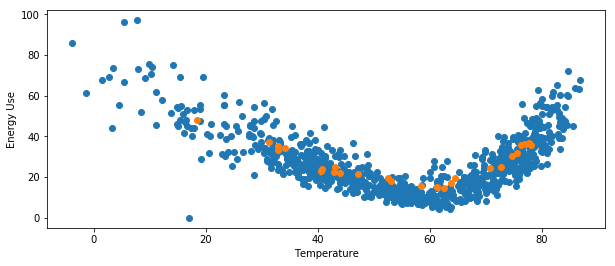

In [11]:
ax = eemeter.plot_energy_signature(meter_data_daily, temperature_data_daily)
eemeter.plot_energy_signature(meter_data_billing, temperature_data_billing, ax=ax)

## Creating a baseline dataset

To make this into a dataset that can support analysis, we need to merge the meter data and temperature data into a single DataFrame. The `merge_temperature_data` function also lets us create a bunch of heating and cooling degree day values if we specify balance points to use. In this case, we'll use the wide balance point ranges recommended in the CalTRACK spec.

We can also filter this meter data to contain just the baseline data.

In [12]:
baseline_meter_data_billing, baseline_warnings_billing = eemeter.get_baseline_data(
    meter_data_billing, end=baseline_end_date, max_days=365, whole_periods=False)

baseline_meter_data_daily, baseline_warnings_daily = eemeter.get_baseline_data(
    meter_data_daily, end=baseline_end_date, max_days=365, whole_periods=False)

In [13]:
baseline_meter_data_billing.tail()

,value
start,
2016-08-22 06:00:00+00:00,942.15
2016-09-22 06:00:00+00:00,632.31
2016-10-24 06:00:00+00:00,538.24
2016-11-23 06:00:00+00:00,921.55
2016-12-19 06:00:00+00:00,NaN


In [14]:
baseline_meter_data_daily.tail()

,value
start,
2016-12-22 00:00:00+00:00,30.79
2016-12-23 00:00:00+00:00,28.74
2016-12-24 00:00:00+00:00,31.63
2016-12-25 00:00:00+00:00,26.45
2016-12-26 00:00:00+00:00,NaN


If there had been any issues (e.g., unexpected gaps in the data) in filtering the data to the baseline period, some warnings would have been reported. This time we got off easy, but that will not always be the case in real-life datasets.

In [15]:
baseline_warnings_billing, baseline_warnings_daily

([], [])

In [16]:
import pandas as pd  # for timedelta
baseline_data_billing = eemeter.merge_temperature_data(
    baseline_meter_data_billing, temperature_data_billing,
    heating_balance_points=range(40, 81),  # a list like this [40, 41, 42, ... 79, 80]
    cooling_balance_points=range(50, 91),
    data_quality=True,  # add some measures of data quality so we can check data sufficiency later
    tolerance=pd.Timedelta('35D'),  # limit temperature data matching to periods of up to 35 days.
)

baseline_data_daily = eemeter.merge_temperature_data(
    baseline_meter_data_daily, temperature_data_daily,
    heating_balance_points=range(40, 81),  # a list like this [40, 41, 42, ... 79, 80]
    cooling_balance_points=range(50, 91),
    data_quality=True,  # add some measures of data quality so we can check data sufficiency later
)

In [17]:
baseline_data_billing.tail()

,meter_value,temperature_not_null,temperature_null,temperature_mean,cdd_50,cdd_51,cdd_52,cdd_53,cdd_54,cdd_55,...,hdd_73,hdd_74,hdd_75,hdd_76,hdd_77,hdd_78,hdd_79,hdd_80,n_days_dropped,n_days_kept
2016-08-22 06:00:00+00:00,30.391935,744.0,0.0,74.667392,24.667392,23.667392,22.667392,21.667392,20.667392,19.667392,...,1.170874,1.622379,2.120833,2.749825,3.422339,4.103347,4.833065,5.609059,0.0,31.0
2016-09-22 06:00:00+00:00,19.759687,768.0,0.0,64.546667,14.637852,13.681497,12.759857,11.853607,10.947357,10.041107,...,9.188073,9.962005,10.789727,11.633477,12.511029,13.455221,14.453333,15.453333,0.0,32.0
2016-10-24 06:00:00+00:00,17.941333,720.0,0.0,53.130458,5.562833,4.901917,4.268583,3.668833,3.190708,2.790708,...,19.869542,20.869542,21.869542,22.869542,23.869542,24.869542,25.869542,26.869542,0.0,30.0
2016-11-23 06:00:00+00:00,35.444231,624.0,0.0,32.976378,0.001250,0.000000,0.000000,0.000000,0.000000,0.000000,...,40.023622,41.023622,42.023622,43.023622,44.023622,45.023622,46.023622,47.023622,0.0,26.0
2016-12-19 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
baseline_data_daily.tail()

,meter_value,temperature_not_null,temperature_null,temperature_mean,cdd_50,cdd_51,cdd_52,cdd_53,cdd_54,cdd_55,...,hdd_73,hdd_74,hdd_75,hdd_76,hdd_77,hdd_78,hdd_79,hdd_80,n_days_dropped,n_days_kept
start,,,,,,,,,,,,,,,,,,,,,
2016-12-22 00:00:00+00:00,30.79,24.0,0.0,37.755833,0.0,0.0,0.0,0.0,0.0,0.0,...,35.244167,36.244167,37.244167,38.244167,39.244167,40.244167,41.244167,42.244167,0.0,1.0
2016-12-23 00:00:00+00:00,28.74,24.0,0.0,34.483333,0.0,0.0,0.0,0.0,0.0,0.0,...,38.516667,39.516667,40.516667,41.516667,42.516667,43.516667,44.516667,45.516667,0.0,1.0
2016-12-24 00:00:00+00:00,31.63,24.0,0.0,40.632500,0.0,0.0,0.0,0.0,0.0,0.0,...,32.367500,33.367500,34.367500,35.367500,36.367500,37.367500,38.367500,39.367500,0.0,1.0
2016-12-25 00:00:00+00:00,26.45,24.0,0.0,39.362500,0.0,0.0,0.0,0.0,0.0,0.0,...,33.637500,34.637500,35.637500,36.637500,37.637500,38.637500,39.637500,40.637500,0.0,1.0
2016-12-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
baseline_data_billing.index.min(), baseline_data_billing.index.max()

(Timestamp('2016-01-22 06:00:00+0000', tz='UTC'),
 Timestamp('2016-12-19 06:00:00+0000', tz='UTC'))

In [20]:
baseline_data_daily.index.min(), baseline_data_daily.index.max()

(Timestamp('2015-12-27 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2016-12-26 00:00:00+0000', tz='UTC', freq='D'))

## Running the CalTRACK Methods

The following use the design matrices that we created in the previous steps and uses them with the CalTRACK method. This gives us a baseline model, which we will dig into a bit.

In [21]:
baseline_model_fit_billing = eemeter.caltrack_method(
    baseline_data_billing,
    use_billing_presets=True,
    weights_col='n_days_kept',
)

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [22]:
baseline_model_fit_daily = eemeter.caltrack_method(
    baseline_data_daily,
)

## Plotting (part 2)

To see what this model fit looks like, we can plot the result.

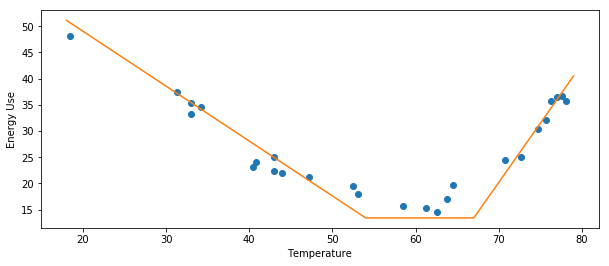

In [23]:
ax = eemeter.plot_energy_signature(meter_data_billing, temperature_data_billing)
baseline_model_fit_billing.plot(ax=ax, temp_range=(18, 80))

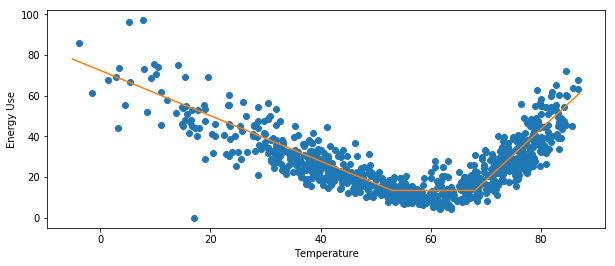

In [24]:
ax = eemeter.plot_energy_signature(meter_data_daily, temperature_data_daily)
baseline_model_fit_daily.plot(ax=ax, temp_range=(-5, 88))

We can also compare the two models and see that there is a slight, but not drastic, difference between them.

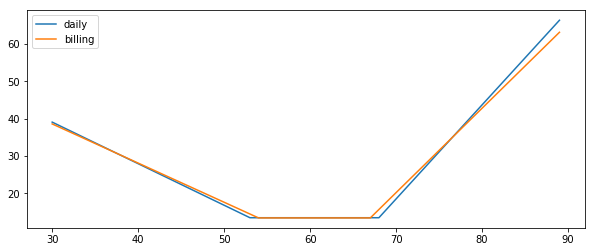

In [25]:
ax = baseline_model_fit_daily.model.plot(color='C0', best=True, label='daily')
ax = baseline_model_fit_billing.model.plot(ax=ax, color='C1', best=True, label='billing')
ax.legend()

If we're interested in seeing more about models the CalTRACK method tried, we can even plot all the model candidates as well. There are a ton of these, so the reduced alpha makes it a bit easier to see what's going on. Each faint line represents a model that was tried and bested by the (orange) selected model, which had the highest r-squared. Candidates appear green if `QUALIFIED` and red if `DISQUALIFIED`.  A model might be disqualified if it had unphysical (i.e., negative) coefficients.

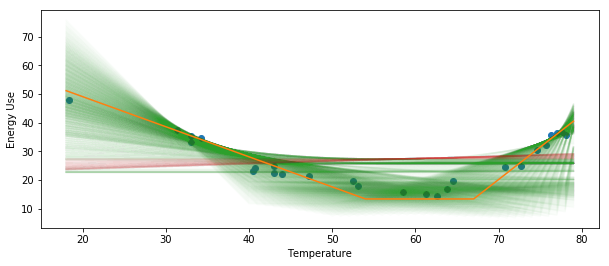

In [26]:
ax = eemeter.plot_energy_signature(meter_data_billing, temperature_data_billing)
baseline_model_fit_billing.plot(
    ax=ax, candidate_alpha=0.02,
    with_candidates=True, temp_range=(18, 80))

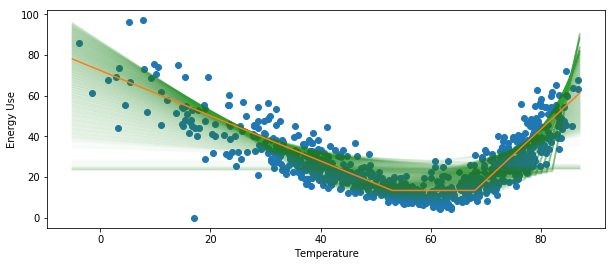

In [27]:
ax = eemeter.plot_energy_signature(meter_data_daily, temperature_data_daily)
baseline_model_fit_daily.plot(
    ax=ax, candidate_alpha=0.02,
    with_candidates=True, temp_range=(-5, 88))

## ModelFit object: status, candidates, warnings, json


In addition to being plottable, the model_fit object is an instance of the class [eemeter.ModelFit](http://eemeter.openee.io/api.html#eemeter.ModelFit) and contains a bunch of interesting information about this modeling process. 

For instance, there's a status. This status is one of the following:

- `'SUCCESS'`: qualified model selected.
- `'NO MODEL'`: no candidate models qualified.
- `'NO DATA'`: no data was given.

In [28]:
baseline_model_fit_billing.status, baseline_model_fit_daily.status

('SUCCESS', 'SUCCESS')

There is also a "best" candidate model:

In [29]:
baseline_model_fit_billing.model, baseline_model_fit_daily.model

(CandidateModel(model_type='cdd_hdd', formula='meter_value ~ cdd_67 + hdd_54', status='QUALIFIED', r_squared=0.994),
 CandidateModel(model_type='cdd_hdd', formula='meter_value ~ cdd_68 + hdd_53', status='QUALIFIED', r_squared=0.768))

And a list of all candidate models that were tried, many of which have (much) lower r-squared than the best model.

In [30]:
baseline_model_fit_billing.candidates[:5]  # (there are a lot, so only showing the first 5)

[CandidateModel(model_type='intercept_only', formula='meter_value ~ 1', status='QUALIFIED', r_squared=0),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_40', status='QUALIFIED', r_squared=0.051),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_41', status='QUALIFIED', r_squared=0.047),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_42', status='QUALIFIED', r_squared=0.041),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_43', status='QUALIFIED', r_squared=0.035)]

In [31]:
baseline_model_fit_daily.candidates[:5] 

[CandidateModel(model_type='intercept_only', formula='meter_value ~ 1', status='QUALIFIED', r_squared=0),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_40', status='QUALIFIED', r_squared=0.273),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_41', status='QUALIFIED', r_squared=0.274),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_42', status='QUALIFIED', r_squared=0.274),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_43', status='QUALIFIED', r_squared=0.273)]

Any associated warnings on both the model_fit object and the best candidate model object:

In [32]:
baseline_model_fit_billing.warnings, baseline_model_fit_billing.model.warnings

([], [])

In [33]:
baseline_model_fit_daily.warnings, baseline_model_fit_daily.model.warnings

([], [])

The best models don't appear to have any issues but the billing model did (see the faint red lines in the chart above).

In [34]:
disqualified_candidates = [
    candidate
    for candidate in baseline_model_fit_billing.candidates
    if candidate.status == 'DISQUALIFIED'
]  # this is a python list comprehension
disqualified_candidates[:10]

[CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_67', status='DISQUALIFIED', r_squared=-0.111),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_68', status='DISQUALIFIED', r_squared=-0.111),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_69', status='DISQUALIFIED', r_squared=-0.109),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_70', status='DISQUALIFIED', r_squared=-0.108),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_71', status='DISQUALIFIED', r_squared=-0.105),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_72', status='DISQUALIFIED', r_squared=-0.102),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_73', status='DISQUALIFIED', r_squared=-0.099),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_74', status='DISQUALIFIED', r_squared=-0.096),
 CandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_75', status='DISQUALIFIED', r_

The warnings associated with the disqualified candidates will be a bit more interesting. For instance, this one was disqualified because the 'beta_hdd' parameter was negative, which is unphysicial behavior that the CalTRACK working group should be considered to be evidence of overfitting:

In [35]:
import json  # for nice indentation
warning = disqualified_candidates[0].warnings[0]
print(json.dumps(warning.json(), indent=2))

{
  "qualified_name": "eemeter.caltrack_daily.hdd_only.beta_hdd_negative",
  "description": "Model fit beta_hdd parameter is negative. Candidate model rejected.",
  "data": {
    "intercept": 27.403096292465268,
    "beta_hdd": -0.0002667900820258473,
    "heating_balance_point": 67
  }
}


The whole model can be serialized. The `.json(with_candidates=True)` flag will also serialize all candidate models results:

In [36]:
print(json.dumps(baseline_model_fit_billing.json(), indent=2))

{
  "status": "SUCCESS",
  "method_name": "caltrack_method",
  "model": {
    "model_type": "cdd_hdd",
    "formula": "meter_value ~ cdd_67 + hdd_54",
    "status": "QUALIFIED",
    "model_params": {
      "intercept": 13.420093629452865,
      "beta_cdd": 2.2578686654124094,
      "beta_hdd": 1.0479347638717031,
      "cooling_balance_point": 67,
      "heating_balance_point": 54
    },
    "r_squared": 0.9944443281461993,
    "warnings": []
  },
  "r_squared": 0.9944443281461993,
  "warnings": [],
  "metadata": {},
  "settings": {
    "fit_cdd": true,
    "minimum_non_zero_cdd": 0,
    "minimum_non_zero_hdd": 0,
    "minimum_total_cdd": 0,
    "minimum_total_hdd": 0,
    "beta_cdd_maximum_p_value": 1,
    "beta_hdd_maximum_p_value": 1
  }
}


In [37]:
print(json.dumps(baseline_model_fit_daily.json(), indent=2))

{
  "status": "SUCCESS",
  "method_name": "caltrack_method",
  "model": {
    "model_type": "cdd_hdd",
    "formula": "meter_value ~ cdd_68 + hdd_53",
    "status": "QUALIFIED",
    "model_params": {
      "intercept": 13.472385591795213,
      "beta_cdd": 2.516255026490126,
      "beta_hdd": 1.1122947857443488,
      "cooling_balance_point": 68,
      "heating_balance_point": 53
    },
    "r_squared": 0.7684732992831353,
    "warnings": []
  },
  "r_squared": 0.7684732992831353,
  "warnings": [],
  "metadata": {},
  "settings": {
    "fit_cdd": true,
    "minimum_non_zero_cdd": 10,
    "minimum_non_zero_hdd": 10,
    "minimum_total_cdd": 20,
    "minimum_total_hdd": 20,
    "beta_cdd_maximum_p_value": 1,
    "beta_hdd_maximum_p_value": 1
  }
}


## CalTRACK Data Sufficiency

Another important part of the CalTRACK methods are the data sufficiency requirements. We can check the data sufficiency requirements of our baseline data. Note that we include the requested end dates to indicate the _intended_ extent of the period should stop at the baseline end date.

In [38]:
baseline_data_sufficiency_billing = eemeter.caltrack_sufficiency_criteria(
    baseline_data_billing, requested_start=None, requested_end=baseline_end_date)

baseline_data_sufficiency_daily = eemeter.caltrack_sufficiency_criteria(
    baseline_data_daily, requested_start=None, requested_end=baseline_end_date)

In [39]:
baseline_data_sufficiency_billing.warnings

[EEMeterWarning(qualified_name=eemeter.caltrack_sufficiency_criteria.too_few_total_days)]

In [40]:
baseline_data_sufficiency_daily.warnings

[]

These warnings carry useful information about the extent of the data sufficiency issues:

In [41]:
print(json.dumps(baseline_data_sufficiency_billing.json(), indent=2))

{
  "status": "FAIL",
  "criteria_name": "caltrack_sufficiency_criteria",
  "warnings": [
    {
      "qualified_name": "eemeter.caltrack_sufficiency_criteria.too_few_total_days",
      "description": "Smaller total data span than the allowable minimum.",
      "data": {
        "min_days": 365,
        "n_days_total": 338
      }
    }
  ],
  "settings": {
    "min_days": 365,
    "min_fraction_daily_coverage": 0.9,
    "min_fraction_daily_temperature_hourly_coverage": 0.9
  }
}


In [42]:
print(json.dumps(baseline_data_sufficiency_daily.json(), indent=2))

{
  "status": "PASS",
  "criteria_name": "caltrack_sufficiency_criteria",
  "warnings": [],
  "settings": {
    "min_days": 365,
    "min_fraction_daily_coverage": 0.9,
    "min_fraction_daily_temperature_hourly_coverage": 0.9
  }
}


## Reporting period metered savings

Now that we have a handle on our data sufficiency, we can now take this baseline model and project forward into the reporting period. This will allow us to calculate metered savings for the reporting period.

First, we need a reporting period. The following gets the reporting period date.

In [43]:
reporting_start_date = metadata_billing['blackout_start_date']

Now we filter data for that period:

In [44]:
reporting_meter_data_billing, warnings = eemeter.get_reporting_data(
    meter_data_billing, start=reporting_start_date, max_days=365)

reporting_meter_data_daily, warnings = eemeter.get_reporting_data(
    meter_data_daily, start=reporting_start_date, max_days=365)

The `eemeter.caltrack_metered_savings` method performs the logic of estimating counterfactual baseline reporting period usage. For this, it requires the fitted baseline model, the reporting period meter data (for its index - so that it can be properly joined later), and corresponding temperature data. Note that this method can return results disaggregated into base load, cooling load, or heating load or as the aggregated usage. We do both here for demonstration purposes.

In [45]:
metered_savings_billing = eemeter.caltrack_metered_savings(
    baseline_model_fit_billing.model, reporting_meter_data_billing,
    temperature_data_billing, with_disaggregated=True
)

metered_savings_daily = eemeter.caltrack_metered_savings(
    baseline_model_fit_daily.model, reporting_meter_data_daily,
    temperature_data_daily, with_disaggregated=True
)

We can join these all into a convenient dataframe.

In [46]:
metered_savings_billing

,reporting_observed,counterfactual_usage,metered_savings,counterfactual_base_load,counterfactual_cooling_load,counterfactual_heating_load
start,,,,,,
2017-01-21 06:00:00+00:00,717.58,871.909019,154.329019,416.022903,0.000000,455.886117
2017-02-21 06:00:00+00:00,682.58,767.491490,84.911490,416.022903,0.000000,351.468587
2017-03-24 06:00:00+00:00,503.42,521.984343,18.564343,429.442996,45.909996,46.631350
2017-04-25 06:00:00+00:00,467.65,597.360739,129.710739,429.442996,145.851730,22.066013
2017-05-27 06:00:00+00:00,929.39,955.441124,26.051124,389.182715,566.258409,0.000000
2017-06-25 06:00:00+00:00,1142.27,1241.312358,99.042358,429.442996,811.869362,0.000000
2017-07-27 06:00:00+00:00,774.62,817.841677,43.221677,416.022903,401.818775,0.000000
2017-08-27 06:00:00+00:00,734.66,752.261054,17.601054,402.602809,349.658245,0.000000
2017-09-26 06:00:00+00:00,526.25,561.458099,35.208099,416.022903,126.621275,18.813922


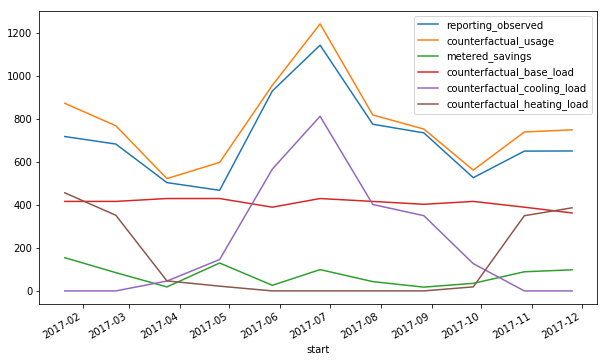

In [47]:
metered_savings_billing.plot(figsize=(10, 6))

In [48]:
metered_savings_daily.head()

,reporting_observed,counterfactual_usage,metered_savings,counterfactual_base_load,counterfactual_cooling_load,counterfactual_heating_load
start,,,,,,
2016-12-26 00:00:00+00:00,12.75,13.472386,0.722386,13.472386,0.0,0.000000
2016-12-27 00:00:00+00:00,22.68,32.476405,9.796405,13.472386,0.0,19.004020
2016-12-28 00:00:00+00:00,28.52,32.419400,3.899400,13.472386,0.0,18.947015
2016-12-29 00:00:00+00:00,36.85,29.588147,-7.261853,13.472386,0.0,16.115761
2016-12-30 00:00:00+00:00,26.87,33.227204,6.357204,13.472386,0.0,19.754819


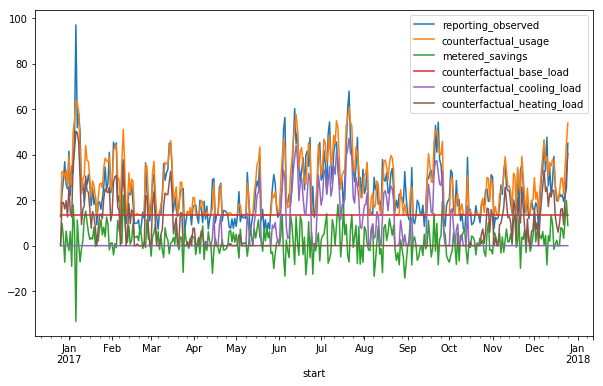

In [49]:
metered_savings_daily.plot(figsize=(10, 6))

And compute metered savings!

In [50]:
total_savings_billing = metered_savings_billing.metered_savings.sum()
percent_savings_billing = total_savings_billing / metered_savings_billing.counterfactual_usage.sum() * 100
print('Billing: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_billing, percent_savings_billing))

total_savings_daily = metered_savings_daily.metered_savings.sum()
percent_savings_daily = total_savings_daily / metered_savings_daily.counterfactual_usage.sum() * 100
print('Daily: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_daily, percent_savings_daily))

Billing: Saved 795.7 kWh in first year (9.3%)
Daily: Saved 814.5 kWh in first year (8.5%)


**NOTE**: These results differ somewhat due to the different lengths of the reporting periods - the billing version of the reporting period was a bit shorter because the billing periods over which we computed savings didn't exactly align with 365 day period we requested, as they did for the daily reporting period data.

## Annual weather-normalized modeled savings

If we want to compute annual weather normalized modeled savings, we'll need a reporting period model. The following code repeats what we did for the baseline period with the reporting period.

In [51]:
reporting_data_billing = eemeter.merge_temperature_data(
    reporting_meter_data_billing, temperature_data_billing,
    heating_balance_points=range(40, 81),  # a list like this [40, 41, 42, ... 79, 80]
    cooling_balance_points=range(50, 91),
    data_quality=True,  # add some measures of data quality so we can check data sufficiency later
    tolerance=pd.Timedelta('35D'),
)

reporting_data_daily = eemeter.merge_temperature_data(
    reporting_meter_data_daily, temperature_data_daily,
    heating_balance_points=range(40, 81),  # a list like this [40, 41, 42, ... 79, 80]
    cooling_balance_points=range(50, 91),
    data_quality=True,  # add some measures of data quality so we can check data sufficiency later
)

In [52]:
reporting_model_fit_billing = eemeter.caltrack_method(
    reporting_data_billing,
    use_billing_presets=True,
    weights_col='n_days_kept',
)
reporting_model_fit_daily = eemeter.caltrack_method(
    reporting_data_daily,
)

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


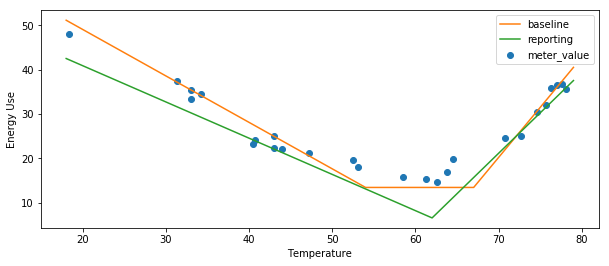

In [53]:
ax = eemeter.plot_energy_signature(meter_data_billing, temperature_data_billing)
ax = baseline_model_fit_billing.model.plot(ax=ax, color='C1', best=True, label='baseline', temp_range=(18, 80))
ax = reporting_model_fit_billing.model.plot(ax=ax, color='C2', best=True, label='reporting', temp_range=(18, 80))
ax.legend()

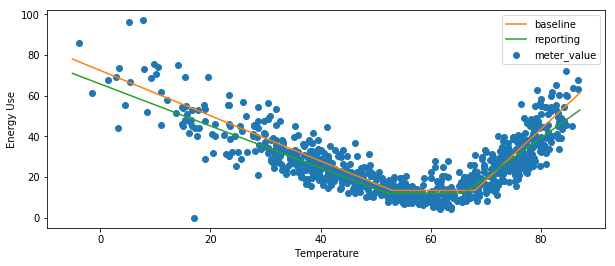

In [54]:
ax = eemeter.plot_energy_signature(meter_data_daily, temperature_data_daily)
ax = baseline_model_fit_daily.model.plot(ax=ax, color='C1', best=True, label='baseline', temp_range=(-5, 88))
ax = reporting_model_fit_daily.model.plot(ax=ax, color='C2', best=True, label='reporting', temp_range=(-5, 88))
ax.legend()

The last thing we need to do before obtaining annualized and weather-normalized results is to obtain normal year temperature data. For simplicity, let's just call 2017 our "normal year". To be completely clear, this is not something you would do in practice, but this demonstrates the functionality. To use real temperature normals, check out the [EEWeather](http://eeweather.openee.io/) package.

In [55]:
normal_year_temperatures = temperature_data_daily[temperature_data_daily.index.year == 2017]
result_index = pd.date_range('2017-01-01', periods=365, tz='UTC')

Now we are ready to obtain our annualized savings.

In [56]:
annualized_savings_billing = eemeter.caltrack_modeled_savings(
    baseline_model_fit_billing.model, reporting_model_fit_billing.model,
    result_index, normal_year_temperatures, with_disaggregated=True
)

annualized_savings_daily = eemeter.caltrack_modeled_savings(
    baseline_model_fit_daily.model, reporting_model_fit_daily.model,
    result_index, normal_year_temperatures, with_disaggregated=True
)

In [57]:
annualized_savings_billing.head()

,modeled_baseline_usage,modeled_reporting_usage,modeled_savings,modeled_baseline_base_load,modeled_baseline_cooling_load,modeled_baseline_heating_load,modeled_reporting_base_load,modeled_reporting_cooling_load,modeled_reporting_heating_load,modeled_base_load_savings,modeled_heating_load_savings,modeled_cooling_load_savings
2017-01-01 00:00:00+00:00,38.822906,32.898922,5.923984,13.420094,0.0,25.402812,6.544231,0.0,26.354691,6.875863,-0.951879,0.0
2017-01-02 00:00:00+00:00,28.393771,24.763770,3.630002,13.420094,0.0,14.973678,6.544231,0.0,18.219539,6.875863,-3.245861,0.0
2017-01-03 00:00:00+00:00,26.275633,23.111535,3.164098,13.420094,0.0,12.855540,6.544231,0.0,16.567304,6.875863,-3.711765,0.0
2017-01-04 00:00:00+00:00,48.524162,40.466299,8.057862,13.420094,0.0,35.104068,6.544231,0.0,33.922069,6.875863,1.182000,0.0
2017-01-05 00:00:00+00:00,53.801823,44.583092,9.218732,13.420094,0.0,40.381729,6.544231,0.0,38.038861,6.875863,2.342869,0.0


The following plot demonstrates that in this case, the billing model represents most of the modeled savings as base load savings. This reflects the behavior seen in the model comparison above.

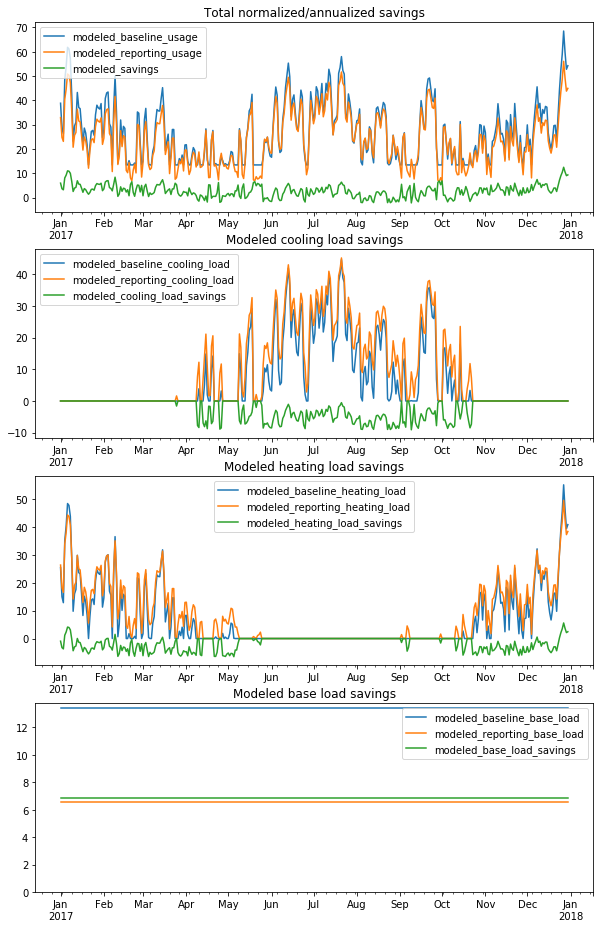

In [58]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 1, figsize=(10, 16))

annualized_savings_billing[[
    'modeled_baseline_usage',
    'modeled_reporting_usage',
    'modeled_savings',
]].plot(ax=axes[0])
axes[0].set_title('Total normalized/annualized savings')

annualized_savings_billing[[
    'modeled_baseline_cooling_load',
    'modeled_reporting_cooling_load',
    'modeled_cooling_load_savings',
]].plot(ax=axes[1])
axes[1].set_title('Modeled cooling load savings')

annualized_savings_billing[[
    'modeled_baseline_heating_load',
    'modeled_reporting_heating_load',
    'modeled_heating_load_savings',
]].plot(ax=axes[2])
axes[2].set_title('Modeled heating load savings')

ax = annualized_savings_billing[[
    'modeled_baseline_base_load',
    'modeled_reporting_base_load',
    'modeled_base_load_savings',
]].plot(ax=axes[3])
axes[3].set_title('Modeled base load savings')
lim = axes[3].set_ylim((0, None))

plt.show()

In [59]:
annualized_savings_daily.head()

,modeled_baseline_usage,modeled_reporting_usage,modeled_savings,modeled_baseline_base_load,modeled_baseline_cooling_load,modeled_baseline_heating_load,modeled_reporting_base_load,modeled_reporting_cooling_load,modeled_reporting_heating_load,modeled_base_load_savings,modeled_heating_load_savings,modeled_cooling_load_savings
2017-01-01 00:00:00+00:00,39.323043,35.088762,4.234281,13.472386,0.0,25.850658,12.155685,0.0,22.933077,1.316701,2.917580,0.0
2017-01-02 00:00:00+00:00,28.253393,24.826921,3.426472,13.472386,0.0,14.781007,12.155685,0.0,12.671236,1.316701,2.109771,0.0
2017-01-03 00:00:00+00:00,26.005167,22.742760,3.262407,13.472386,0.0,12.532781,12.155685,0.0,10.587075,1.316701,1.945706,0.0
2017-01-04 00:00:00+00:00,49.620112,44.634401,4.985711,13.472386,0.0,36.147727,12.155685,0.0,32.478716,1.316701,3.669011,0.0
2017-01-05 00:00:00+00:00,55.221907,49.827404,5.394503,13.472386,0.0,41.749521,12.155685,0.0,37.671719,1.316701,4.077802,0.0


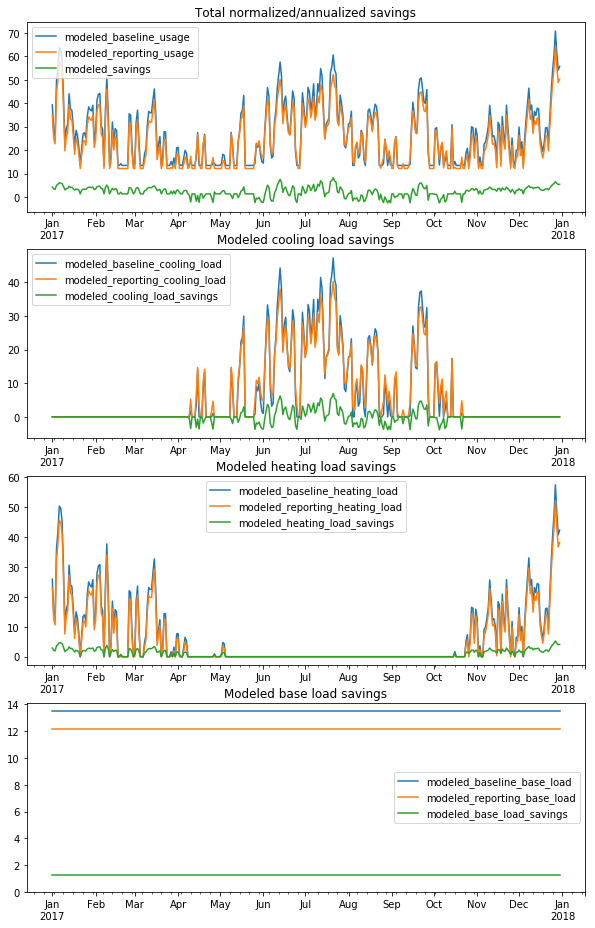

In [60]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 1, figsize=(10, 16))

annualized_savings_daily[[
    'modeled_baseline_usage',
    'modeled_reporting_usage',
    'modeled_savings',
]].plot(ax=axes[0])
axes[0].set_title('Total normalized/annualized savings')

annualized_savings_daily[[
    'modeled_baseline_cooling_load',
    'modeled_reporting_cooling_load',
    'modeled_cooling_load_savings',
]].plot(ax=axes[1])
axes[1].set_title('Modeled cooling load savings')

annualized_savings_daily[[
    'modeled_baseline_heating_load',
    'modeled_reporting_heating_load',
    'modeled_heating_load_savings',
]].plot(ax=axes[2])
axes[2].set_title('Modeled heating load savings')

ax = annualized_savings_daily[[
    'modeled_baseline_base_load',
    'modeled_reporting_base_load',
    'modeled_base_load_savings',
]].plot(ax=axes[3])
axes[3].set_title('Modeled base load savings')
lim = axes[3].set_ylim((0, None))

plt.show()

In this case, as totals, the annualized savings look pretty similar to the metered savings.

In [61]:
total_savings_billing = annualized_savings_billing.modeled_savings.sum()
percent_savings_billing = total_savings_billing / annualized_savings_billing.modeled_baseline_usage.sum() * 100
print('Billing: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_billing, percent_savings_billing))

total_savings_daily = annualized_savings_daily.modeled_savings.sum()
percent_savings_daily = total_savings_daily / annualized_savings_daily.modeled_baseline_usage.sum() * 100
print('Daily: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_daily, percent_savings_daily))

Billing: Saved 983.5 kWh in first year (10.1%)
Daily: Saved 824.1 kWh in first year (8.5%)


Next steps
----------

Congrats! You've finished the basic tutorial. If this whet your appetite, you might be interested in digging deeper. The following are all highly recommended as ways to learn more about open energy efficiency metering:

 - Read the docs at http://eemeter.openee.io
 - Match sites or obtain weather data from public sources with [EEWeather](http://eeweather.openee.io)
 - Try out the eemeter on your own data. You might find these useful: [eemeter data loading methods](http://eemeter.openee.io/api.html#data-loading)
 - Try another sample.

The following prints the names of the other samples to try out with this notebook, if interested:

In [62]:
eemeter.samples()

['il-electricity-cdd-hdd-billing_bimonthly',
 'il-electricity-cdd-hdd-billing_monthly',
 'il-electricity-cdd-hdd-daily',
 'il-electricity-cdd-hdd-hourly',
 'il-electricity-cdd-only-billing_bimonthly',
 'il-electricity-cdd-only-billing_monthly',
 'il-electricity-cdd-only-daily',
 'il-electricity-cdd-only-hourly',
 'il-gas-hdd-only-billing_bimonthly',
 'il-gas-hdd-only-billing_monthly',
 'il-gas-hdd-only-daily',
 'il-gas-hdd-only-hourly',
 'il-gas-intercept-only-billing_bimonthly',
 'il-gas-intercept-only-billing_monthly',
 'il-gas-intercept-only-daily',
 'il-gas-intercept-only-hourly']